### Experiments

These experiments are related to the section 4.2 of the acticle, where an analysis of average accuracy was made. <br>
Here, I'm comparing the `SCARGC_1NN` to 3 another clasifiers: 
- `Static 1NN`, where the classification model isn't updated;
- `Sliding 1NN`, where the model is updated using a static window; and
- `Landmark 1NN`, where the model is updated using an incremental window.

The results are shown in the end, using a Grouped Bar Chart, with the accuracy of each algorithm in the 16 synthetic datasets.

In [12]:
using Pkg
Pkg.activate("../")

using StatsPlots, NearestNeighbors, SCARGC

 Activating environment at `D:\Projects\Julia\SCARGC.jl\Project.toml`


```julia
nearestNeighborStatic(
    dataset::Array{T, 2} where {T<:Number} = "dataset used in label prediction"
    percentTraining::Float64               = "the amount of data that is going to be used as training model."
)
```

`nearestNeiborStatic` is a function to predict values from a dataset using the Nearest Neighbor algorithm in it's static form. It means that the classification model isn't updated along the code, being the same from the beginning of the frunction execution until the end.

In [13]:
function nearestNeighborStatic(dataset::Array{T, 2} where {T<:Number}, percentTraining::Float64)
    labeledData, labeledDataLabels, streamData, streamLabels, _ = SCARGC.fitData(dataset, percentTraining)
    
    tree = KDTree(permutedims(labeledData))
    accuracyVector = zeros(size(streamData, 1))
    
    for stream = 1:size(streamData, 1)
        index, _ = knn(tree, streamData[stream, :], 1, true)
        
        if (streamLabels[stream] == labeledDataLabels[index[1]])
            global accuracyVector[stream] = 1
        end
    end
    
    finalAccuracy = (sum(accuracyVector)/size(streamData, 1)) * 100
    
    println(finalAccuracy)
    
    return finalAccuracy
end

nearestNeighborStatic (generic function with 1 method)

```julia
nearestNeighborSliding(
    dataset::Array{T, 2} where {T<:Number} = "dataset used in label prediction"
    percentTraining::Float64               = "the amount of data that is going to be used as training model."
)
```

`nearestNeiborSliding` is a function to predict values from a dataset using the Nearest Neighbor algorithm in it's sliding window form. It means that the classification model is updated by a `window`, with the size defined as 50, that receives the instances and it's labels. <br>
It represents a **0 verification latency scenario.**

In [14]:
function nearestNeighborSliding(dataset::Array{T, 2} where {T<:Number}, percentTraining::Float64)
    labeledData, labeledDataLabels, streamData, streamLabels, _ = SCARGC.fitData(dataset, percentTraining)
    
    tree = KDTree(permutedims(labeledData))
    accuracyVector = zeros(size(streamData, 1))
    
    windowSize = 50
    data = zeros(50, size(streamData, 2) + 1)
    dataStreamIndex = 1
    
    for stream = 1:size(streamData, 1)
        index, _ = knn(tree, streamData[stream, :], 1, true)
        
        if (streamLabels[stream] == labeledDataLabels[index[1]])
            global accuracyVector[stream] = 1
        end
        
        data[dataStreamIndex, 1:end-1] = streamData[stream, :]
        data[dataStreamIndex, end] = streamLabels[stream]
        dataStreamIndex += 1
        
        if stream % windowSize == 0
            labeledData = data[:, 1:end-1]
            labeledDataLabels = data[:, end]
            data = zeros(50, size(streamData, 2) + 1)
            dataStreamIndex = 1
            tree = KDTree(permutedims(labeledData))
        end
    end
    
    finalAccuracy = (sum(accuracyVector)/size(streamData, 1)) * 100
    
    println(finalAccuracy)
    
    return finalAccuracy
end

nearestNeighborSliding (generic function with 1 method)

```julia
nearestNeighborLandmark(
    dataset::Array{T, 2} where {T<:Number} = "dataset used in label prediction"
    percentTraining::Float64               = "the amount of data that is going to be used as training model."
)
```

`nearestNeiborLandmark` is also a function to predict values from a dataset using the Nearest Neighbor algorithm in it's incremental window form. It means that the classification model is updated by a `window`, with the size defined as 50 and that grows untill 100 (2 * N) before updating the model. When the maximum is reached, the N oldest data is dropped. <br>
It also represents a **0 verification latency scenario.**

In [15]:
function nearestNeighborLandmark(dataset::Array{T, 2} where {T<:Number}, percentTraining::Float64)
    labeledData, labeledDataLabels, streamData, streamLabels, _ = SCARGC.fitData(dataset, percentTraining)
    
    tree = KDTree(permutedims(labeledData))
    accuracyVector = zeros(size(streamData, 1))
    
    windowSize = 50
    maxWindowSize = 100
    
    data = zeros(100, size(streamData, 2) + 1)
    dataStreamIndex = 1
    
    for stream = 1:size(streamData, 1)
        index, _ = knn(tree, streamData[stream, :], 1, true)
        
        if (streamLabels[stream] == labeledDataLabels[index[1]])
            global accuracyVector[stream] = 1
        end
        
        data[dataStreamIndex, 1:end-1] = streamData[stream, :]
        data[dataStreamIndex, end] = streamLabels[stream]
        dataStreamIndex += 1
        
        if dataStreamIndex == maxWindowSize
            labeledData = data[1:windowSize, 1:end-1]
            labeledDataLabels = data[1:windowSize, end]
            tree = KDTree(permutedims(labeledData))
            
            data[1:windowSize, :] = data[windowSize+1:end, :]
            dataStreamIndex = 50
        end
    end
    
    finalAccuracy = (sum(accuracyVector)/size(streamData, 1)) * 100
    
    println(finalAccuracy)
    
    return finalAccuracy
end

nearestNeighborLandmark (generic function with 1 method)

Defining some variables that are going to be usefull along the codes execution.

#### Variables

`path` represents the path that the synthetic data is; <br>
`datasets` represents the datasets' names (the name of the file); <br>
`K_values` represents all the K values for each dataset; <br>
`rowCount` represents the amount of rows that each dataset has; <br>
`featureCount` represents the amount of features that each dataset has; <br>
`poolValues` represents the `poolSize` for each dataset; <br>
`trainingValues` represents the `percentTraining` for each dataset.

In [16]:
path = "../src/datasets/synthetic/"

datasets = [
    "1CDT.txt", "2CDT.txt", "1CHT.txt", "2CHT.txt", "4CR.txt", "4CRE-V1.txt", 
    "4CRE-V2.txt", "5CVT.txt", "1CSurr.txt", "4CE1CF.txt", "FG_2C_2D.txt", "UG_2C_2D.txt", 
    "UG_2C_3D.txt", "UG_2C_5D.txt", "MG_2C_2D.txt", "GEARS_2C_2D.txt"
]

K_values = [2, 2, 2, 2, 4, 4, 4, 5, 4, 5, 4, 2, 2, 2, 4, 2]

rowCounts = [
    16000, 16000, 16000, 16000, 144400, 125000, 183000, 24000, 55283, 
    173250, 200000, 100000, 200000, 200000, 200000, 200000
]

featureCount = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 5, 2, 2]

poolValues = [300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300]

trainingValues = [
    0.3125, 0.3125, 0.3125, 0.3125, 0.0346, 0.04, 0.0273, 0.125, 
    0.0904, 0.0288, 0.05, 0.025, 0.025, 0.025, 0.025, 0.025
]

16-element Array{Float64,1}:
 0.3125
 0.3125
 0.3125
 0.3125
 0.0346
 0.04
 0.0273
 0.125
 0.0904
 0.0288
 0.05
 0.025
 0.025
 0.025
 0.025
 0.025

Creating the X axis ticks labels' values and the matrix to store the algoritms' accuracies with each dataset.

In [17]:
x = [
    "1CDT", "2CDT", "1CHT", "2CHT", "4CR", "4CRE-V1", "4CRE-V2", "5CVT", 
    "1CSurr", "4CE1CF", "FG_2C_2D", "UG_2C_2D", "UG_2C_3D", "UG_2C_5D", 
    "MG_2C_2D", "GEARS_2C_2D"
]

accuracies = zeros(16, 4)

16×4 Array{Float64,2}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [18]:
for i = 1:4
    data = SCARGC.extractValuesFromFile(path * datasets[i], rowCounts[i], featureCount[i] + 1)
    _, accuracy = SCARGC.scargc_1NN(data, trainingValues[i], poolValues[i], K_values[i])
    ac = nearestNeighborStatic(data, trainingValues[i])
    ac2 = nearestNeighborSliding(data, trainingValues[i])
    ac3 = nearestNeighborLandmark(data, trainingValues[i])
    accuracies[i, 1] = accuracy
    accuracies[i, 2] = ac
    accuracies[i, 3] = ac2
    accuracies[i, 4] = ac3
end

99.75548589341693

<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means inste


99.07210031347962
99.73040752351096
99.7115987460815
90.9090909090909
55.097178683385586
94.20062695924764

<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means inste


93.79937304075236
99.24764890282131
94.53918495297806
99.04702194357367
99.09717868338558

<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means inste


85.97492163009404
54.57680250783699
85.29780564263322
85.01567398119121


<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means inste

In [ ]:
for i = 5:7
    data = SCARGC.extractValuesFromFile(path * datasets[i], rowCounts[i], featureCount[i] + 1)
    _, accuracy = SCARGC.scargc_1NN(data, trainingValues[i], poolValues[i], K_values[i])
    ac = nearestNeighborStatic(data, trainingValues[i])
    ac2 = nearestNeighborSliding(data, trainingValues[i])
    ac3 = nearestNeighborLandmark(data, trainingValues[i])
    accuracies[i, 1] = accuracy
    accuracies[i, 2] = ac
    accuracies[i, 3] = ac2
    accuracies[i, 4] = ac3
end

<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means inste

99.95981988223069
25.26151714582612
99.97367509525459
99.97852441981296

<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means inste


97.45738295318127
25.225290116046416
97.62464985994399

In [115]:
for i = 8:10
    data = SCARGC.extractValuesFromFile(path * datasets[i], rowCounts[i], featureCount[i] + 1)
    _, accuracy = SCARGC.scargc_1NN(data, trainingValues[i], poolValues[i], K_values[i])
    ac = nearestNeighborStatic(data, trainingValues[i])
    ac2 = nearestNeighborSliding(data, trainingValues[i])
    ac3 = nearestNeighborLandmark(data, trainingValues[i])
    accuracies[i, 1] = accuracy
    accuracies[i, 2] = ac
    accuracies[i, 3] = ac2
    accuracies[i, 4] = ac3
end

licit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: Run

84.83521068001669
42.99123904881101
87.1964956195244
86.21610346266166


<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means inste

94.29145619466624
65.55139137834266
97.29509532344794
97.30414788260642


<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means inste

94.0998845265589
94.70438799076213
96.12471131639722
96.16628175519631


In [116]:
for i = 11:13
    data = SCARGC.extractValuesFromFile(path * datasets[i], rowCounts[i], featureCount[i] + 1)
    _, accuracy = SCARGC.scargc_1NN(data, trainingValues[i], poolValues[i], K_values[i])
    ac = nearestNeighborStatic(data, trainingValues[i])
    ac2 = nearestNeighborSliding(data, trainingValues[i])
    ac3 = nearestNeighborLandmark(data, trainingValues[i])
    accuracies[i, 1] = accuracy
    accuracies[i, 2] = ac
    accuracies[i, 3] = ac2
    accuracies[i, 4] = ac3
end

licit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: Run

95.19209604802401
82.89894947473738
93.20860430215107
93.20760380190094


<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means inste

95.52888222055513
45.87146786696674
93.9774943735934
94.09752438109528


<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means inste

94.7776944236059
64.0925231307827
92.37409352338084
92.28307076769192


In [117]:
for i = 14:16
    data = SCARGC.extractValuesFromFile(path * datasets[i], rowCounts[i], featureCount[i] + 1)
    _, accuracy = SCARGC.scargc_1NN(data, trainingValues[i], poolValues[i], K_values[i])
    ac = nearestNeighborStatic(data, trainingValues[i])
    ac2 = nearestNeighborSliding(data, trainingValues[i])
    ac3 = nearestNeighborLandmark(data, trainingValues[i])
    accuracies[i, 1] = accuracy
    accuracies[i, 2] = ac
    accuracies[i, 3] = ac2
    accuracies[i, 4] = ac3
end

licit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: Run

91.01675418854714
69.20630157539385
88.55613903475869
88.56014003500874


<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means inste

92.7586896724181
51.58789697424356
89.91497874468617
89.81445361340336


<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
<string>:11: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means inste

95.89697424356089
94.96224056014003
98.75718929732433
98.72868217054264


Here, the chart is plotted with 900px of width and 400pf of height. <br>
The X ticks labels show the dataset names and the Y axis shows the accuracy of the algorithm.

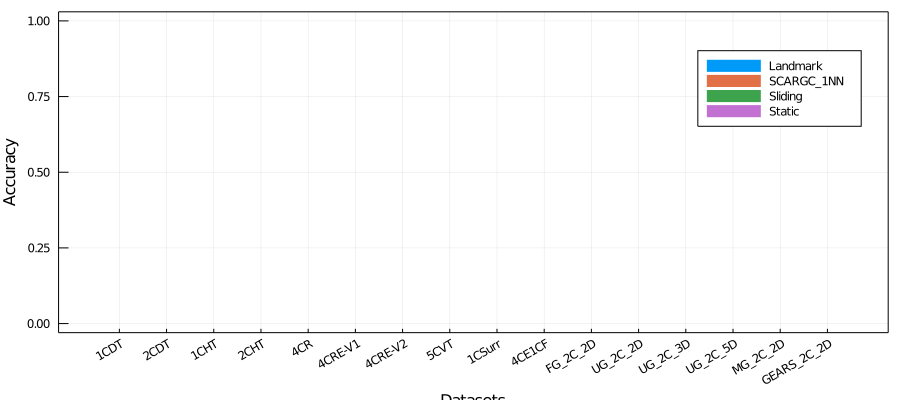

In [11]:
gr(size=(900,400))
ctg = repeat(["SCARGC_1NN", "Static", "Sliding", "Landmark"], inner=16)
groupedbar(accuracies, group = ctg, xlabel = "Datasets", 
    ylabel = "Accuracy", bar_position = :dodge, w = 0, framestyle = :box, bar_width = 0.67, xticks=(1:16, x), xrotation=30)